In [95]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype

from scipy import stats

from scipy.stats import pearsonr,spearmanr, boxcox_normmax, chi2_contingency, chi2, f, shapiro
from scipy.special import boxcox1p

import statsmodels.api as sm
from statsmodels.formula.api import ols 

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Removing outliers

In [4]:
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>300000)].index, inplace = True)

In [5]:
train.shape

(1458, 81)

In [6]:
sale_price_df = train[['SalePrice']].copy()

#### rbinding train and test data

In [7]:
data = pd.concat([train.drop(columns='SalePrice'), test], axis = 0)
data.shape

(2917, 80)

### checking for presence of null

In [8]:
data.isnull().sum()[data.isnull().sum()!=0]

MSZoning           4
LotFrontage      486
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2347
MiscFeature     2812
SaleType           1
dtype: int64

Filling NA values of numerical columns

In [9]:
for col in ['BsmtHalfBath','BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

for col in ['LotFrontage', 'MasVnrArea']:
    data[col] = data[col].fillna(data[col].median())
    
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [10]:
for col in ['MasVnrType', 'Electrical']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())
    
for col in ['Alley', 'GarageType', 'GarageFinish', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1', 'PoolQC',
            'BsmtFinType2', 'FireplaceQu', 'GarageQual',  'GarageCond','Fence', 'MiscFeature']:
    data[col] = data[col].fillna('None')
    
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
data['GarageCond'] = data['GarageCond'].fillna('None')
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [11]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

### Creating new features

In [12]:
data['Yrs_since_remodel'] = data['YearRemodAdd'] - data['YearBuilt']
data['House_Qual'] = data['OverallQual'] + data['OverallCond']
data['Total_bathrooms'] = data['BsmtFullBath'] + data['BsmtHalfBath'] + data['FullBath'] + data['HalfBath']
data['Total_basement_SF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['TotalBsmtSF']
data['Total_sqr_footage'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF']

In [13]:
data.loc[data['Yrs_since_remodel']<0, 'Yrs_since_remodel'] = 0

### Dropping ID column

In [14]:
data.drop(columns = 'Id', inplace = True)


### Dealing with all object/category type columns

Converting object columns to ordinal category type

In [15]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual','GarageCond']:
    data[col] = data[col].astype(cat_type).cat.codes
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['PoolQC'] = data['PoolQC'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType2', 'BsmtFinType1']:
    data[col] = data[col].astype(cat_type).cat.codes

In [16]:
cat_type = CategoricalDtype(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True)
data['Fence'] = data['Fence'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['KitchenQual'] = data['KitchenQual'].astype(cat_type).cat.codes
data['HeatingQC'] = data['HeatingQC'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)
data['Utilities'] = data['Utilities'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['Sev', 'Mod', 'Gtl'], ordered=True)
data['LandSlope'] = data['LandSlope'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual', 'ExterCond']:
    data[col] = data[col].astype(cat_type).cat.codes
    
cat_type = CategoricalDtype(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],ordered=True)
data['Functional'] = data['Functional'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type).cat.codes

cat_type = CategoricalDtype(['N', 'P', 'Y'],ordered=True)
data['PavedDrive'] = data['PavedDrive'].astype(cat_type).cat.codes


### Create new features

In [17]:
data['Has_Garage'] = np.where(data['GarageArea']>0,1,0)
data['Has_2ndFlr'] = np.where(data['2ndFlrSF']>0,1,0)
data['Has_Pool'] = np.where(data['PoolArea']>0 , 1, 0)
data['Has_basement'] = np.where(data['Total_basement_SF'] > 0, 1, 0)
data['Has_fireplace'] = np.where(data['Fireplaces']>0,1,0)
data['Has_wooddeck'] = np.where(data['WoodDeckSF']>0,1,0)
data['Has_Open_Porch'] = np.where(data['OpenPorchSF']>0,1,0)
data['Has_EnclosedPorch'] = np.where(data['EnclosedPorch']>0,1,0)
data['Has_3SsnPorch'] = np.where(data['3SsnPorch']>0,1,0)
data['Has_ScreenPorch'] = np.where(data['ScreenPorch']>0,1,0)

In [18]:
data.shape

(2917, 94)

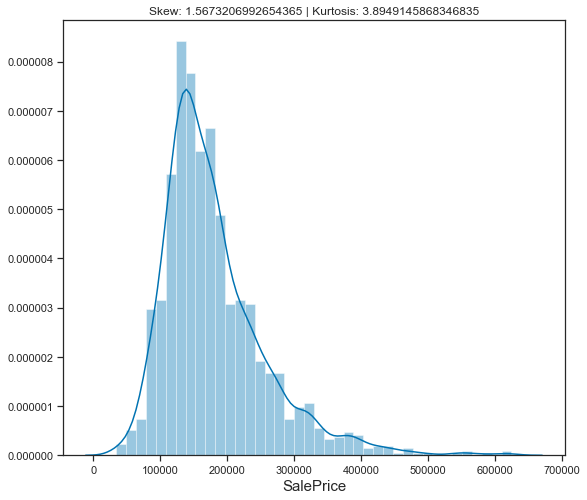

In [19]:
sns.distplot(sale_price_df['SalePrice']);
plt.title("Skew: {} | Kurtosis: {}".format(sale_price_df['SalePrice'].skew(), sale_price_df['SalePrice'].kurt()));

In [20]:
from scipy.stats import probplot

In [21]:
numeric_columns = data.select_dtypes('number').columns
numeric_columns = numeric_columns[~numeric_columns.str.contains('^Has')]
numeric_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold',
       'YrSold', 'Yrs_since_remodel', 'House_Qual', 'Total_bathrooms',
       'Total_basement_SF', 'Total_sqr_footage'],
      

In [22]:
len(numeric_columns)

63

In [23]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()
X_train = pd.concat([X_train,sale_price_df['SalePrice']], axis = 1)

In [24]:
len(data.columns)

94

In [25]:
len(X_train.columns)

95

In [26]:
for col in X_train.select_dtypes('category').columns:
    X_train[col] = X_train[col].cat.codes

In [27]:
numeric_columns = numeric_columns.to_list()

In [28]:
len(numeric_columns)

63

### Use heatmap to check for multicorrelation

In [29]:
def generate_heatmap(df):
    # Generate a heatmap with the upper triangular matrix masked
    # Compute the correlation matrix
    corr = df.corr(method="spearman")
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    plt.figure(figsize = (15,9));
    # Draw the heatmap with the mask 
    sns.heatmap(corr, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
    plt.title("Correlation heatmap");
    return

### CHeck correlation of predictor variables with target variables

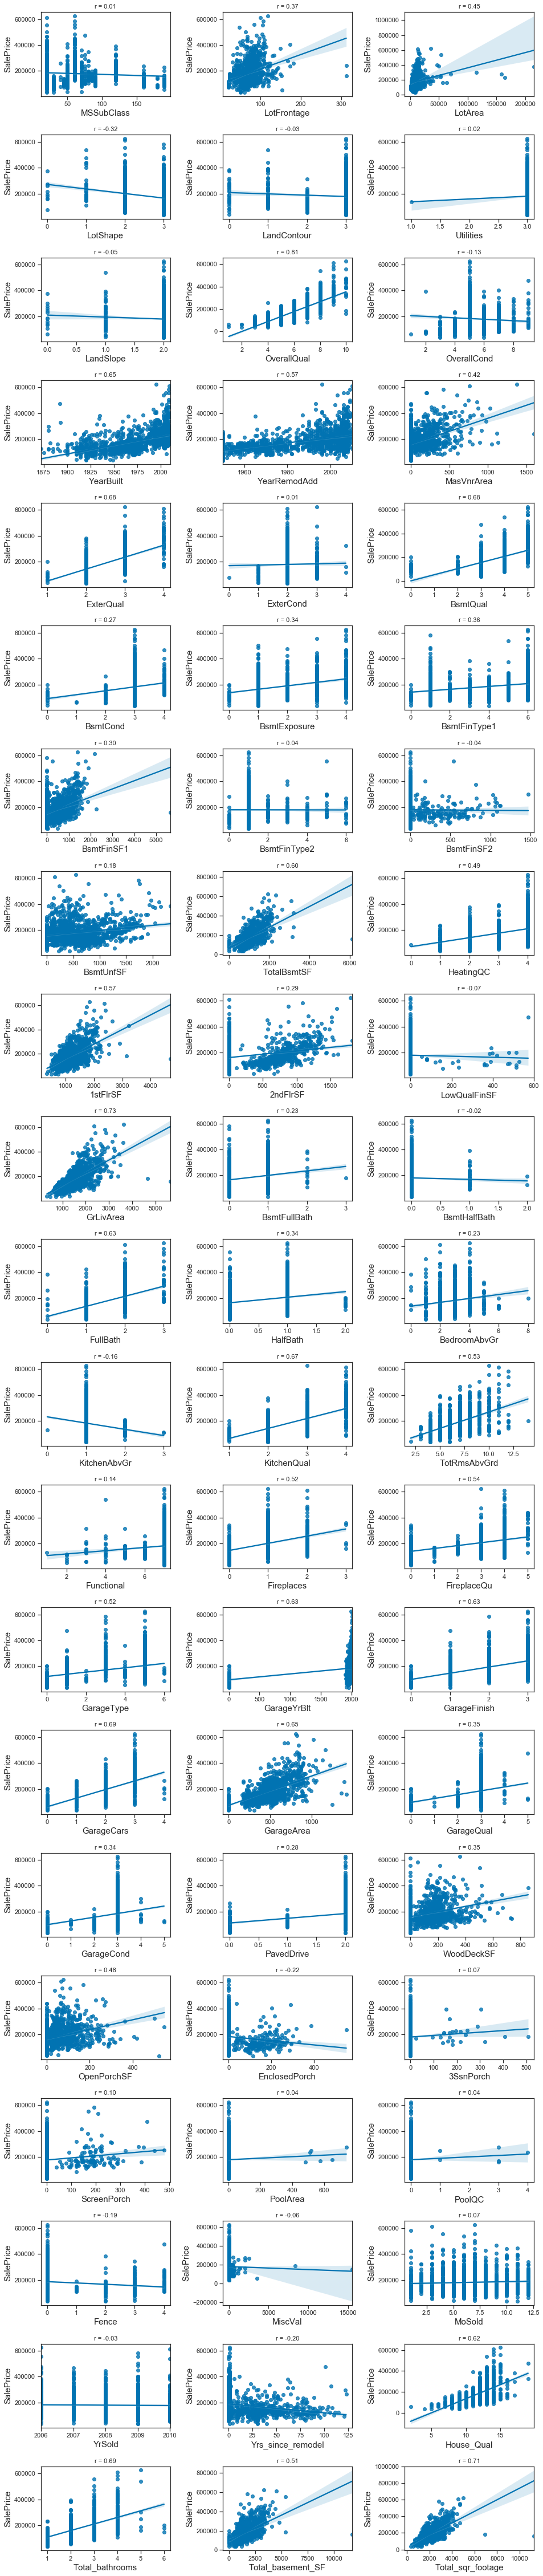

In [30]:
import math
correlation_results_list = []
ncols = 3
nrows = math.ceil(len(numeric_columns)/ncols)
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numeric_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice'], ax = ax)
    stp = spearmanr(X_train[col], X_train['SalePrice'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [31]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df

,column_name,correlation
0,MSSubClass,0.005997
1,LotFrontage,0.372085
2,LotArea,0.454485
3,LotShape,0.319116
4,LandContour,0.026357
5,Utilities,0.016682
6,LandSlope,0.050981
7,OverallQual,0.809032
8,OverallCond,0.129791
9,YearBuilt,0.652639


In [32]:
columns_with_high_corr = correlation_df.loc[correlation_df['correlation']>=0.6, 'column_name'].to_list()
columns_with_high_corr

['OverallQual',
 'YearBuilt',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'House_Qual',
 'Total_bathrooms',
 'Total_sqr_footage']

Dropping numeric columns having low correlation

In [33]:
columns_with_low_corr = correlation_df[correlation_df['correlation']<0.6]['column_name'].to_list()

## Dropping columns having low correlation with SalePrice

In [34]:
data.drop(columns = columns_with_low_corr, inplace = True)
X_train.drop(columns = columns_with_low_corr, inplace = True)

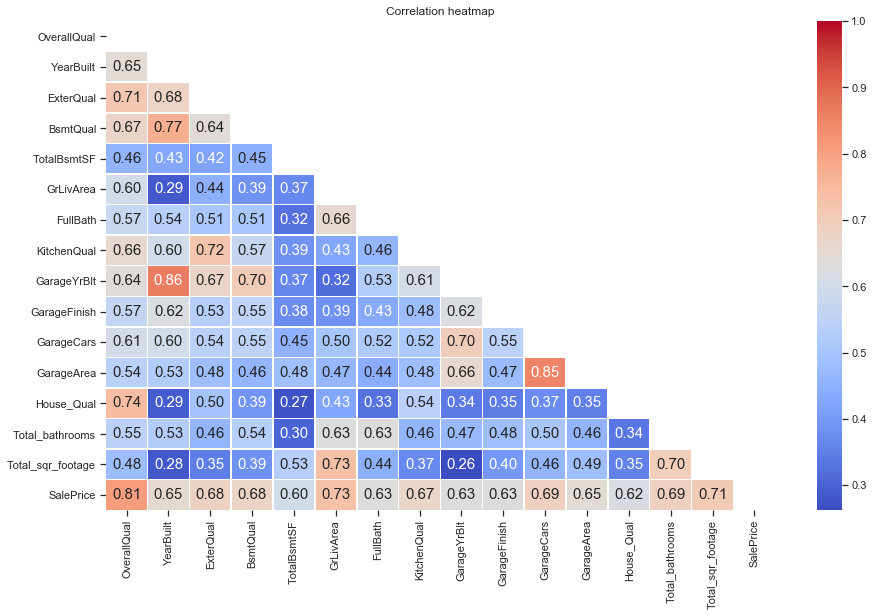

In [35]:
generate_heatmap(X_train[columns_with_high_corr+['SalePrice']])

#### Dropping columns to avoid multicolinearity
- OverallQual with __House_Qual__
- __YearBuilt__ with __GarageYrBlt__ and BsmtQual
- GrLivArea with __Total_sqr_footage__ and __FullBath__
- GarageCars with __GarageYrBlt__
- GarageCars with __GarageArea__
- __Total_bathrooms__ with Total_sqr_footage
- ExterQual with __KitchenQual__

In [36]:
t = ['Total_sqr_footage', 'GarageArea', 'GarageYrBlt', 'GarageYrBlt', 'House_Qual', 'YearBuilt', 'KitchenQual', 'FullBath']

In [37]:
len(data.columns)

46

In [38]:
len(X_train.columns)

47

In [39]:
data.drop(columns = t, inplace = True)
X_train.drop(columns = t, inplace = True)

In [40]:
numeric_cols = pd.Series(columns_with_high_corr)[~pd.Series(columns_with_high_corr).isin(t)].to_list() + ['SalePrice']

In [41]:
category_cols = pd.Series(X_train.columns[~pd.Series(X_train.columns).isin(numeric_cols)]).to_list()
category_cols

['MSZoning',
 'Street',
 'Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'Has_Garage',
 'Has_2ndFlr',
 'Has_Pool',
 'Has_basement',
 'Has_fireplace',
 'Has_wooddeck',
 'Has_Open_Porch',
 'Has_EnclosedPorch',
 'Has_3SsnPorch',
 'Has_ScreenPorch']

In [42]:
del(t)

### Nominal Categorical and continuous (target) variable

In [43]:
global categ_columns_with_high_association, categ_columns_with_low_association
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice', df = X_train):
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
    print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = df).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
    print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
        print("F-statistic is more than F-critical")
        print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
        print("F-statistic is less than F-critical")
        print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
    print('-'*30)

In [44]:
for col in category_cols:
    perform_anova_and_its_results(col)

F_Critical: 2.378
F_statistic: 46.312
F-statistic is more than F-critical
There is an association between MSZoning and SalePrice
------------------------------
F_Critical: 3.848
F_statistic: 2.562
F-statistic is less than F-critical
There is no association between Street and SalePrice
------------------------------
F_Critical: 3.002
F_statistic: 15.824
F-statistic is more than F-critical
There is an association between Alley and SalePrice
------------------------------
F_Critical: 2.378
F_statistic: 8.513
F-statistic is more than F-critical
There is an association between LotConfig and SalePrice
------------------------------
F_Critical: 1.525
F_statistic: 73.984
F-statistic is more than F-critical
There is an association between Neighborhood and SalePrice
------------------------------
F_Critical: 1.945
F_statistic: 6.408
F-statistic is more than F-critical
There is an association between Condition1 and SalePrice
------------------------------
F_Critical: 2.016
F_statistic: 2.216
F-st

In [45]:
categ_columns_with_low_association

['Street', 'Has_Pool', 'Has_3SsnPorch']

In [46]:
categ_columns_with_high_association[:8]

['MSZoning',
 'Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle']

#### Dropping columns

In [47]:
data.drop(columns = categ_columns_with_low_association, inplace = True)
X_train.drop(columns = categ_columns_with_low_association, inplace = True)

In [48]:
X_train.dtypes

MSZoning              object
Alley                 object
LotConfig             object
Neighborhood          object
Condition1            object
Condition2            object
BldgType              object
HouseStyle            object
OverallQual            int64
RoofStyle             object
RoofMatl              object
Exterior1st           object
Exterior2nd           object
MasVnrType            object
ExterQual               int8
Foundation            object
BsmtQual                int8
TotalBsmtSF          float64
Heating               object
CentralAir            object
Electrical            object
GrLivArea              int64
GarageFinish            int8
GarageCars           float64
MiscFeature           object
SaleType              object
SaleCondition         object
Total_bathrooms      float64
Has_Garage             int32
Has_2ndFlr             int32
Has_basement           int32
Has_fireplace          int32
Has_wooddeck           int32
Has_Open_Porch         int32
Has_EnclosedPo

## Association between 2 nominal binary variables
Can be used to avoid multicolinearity

In [49]:
def phi_coefficient(a,b):
    temp = pd.crosstab(a,b)
    nr = (temp.iloc[1,1] * temp.iloc[0,0]) - (temp.iloc[0,1]*temp.iloc[1,0])
    dr = np.sqrt(np.product(temp.apply(sum, axis = 'index')) * np.prod(temp.apply(sum, axis = 'columns')))
    return(nr/dr)

In [50]:
cat_binary_cols = []
for col in X_train.select_dtypes(['int32', 'object']).columns:
    if (X_train[col].nunique()==2):
        cat_binary_cols.append(col)
        
cat_binary_cols

['CentralAir',
 'Has_Garage',
 'Has_2ndFlr',
 'Has_basement',
 'Has_fireplace',
 'Has_wooddeck',
 'Has_Open_Porch',
 'Has_EnclosedPorch',
 'Has_ScreenPorch']

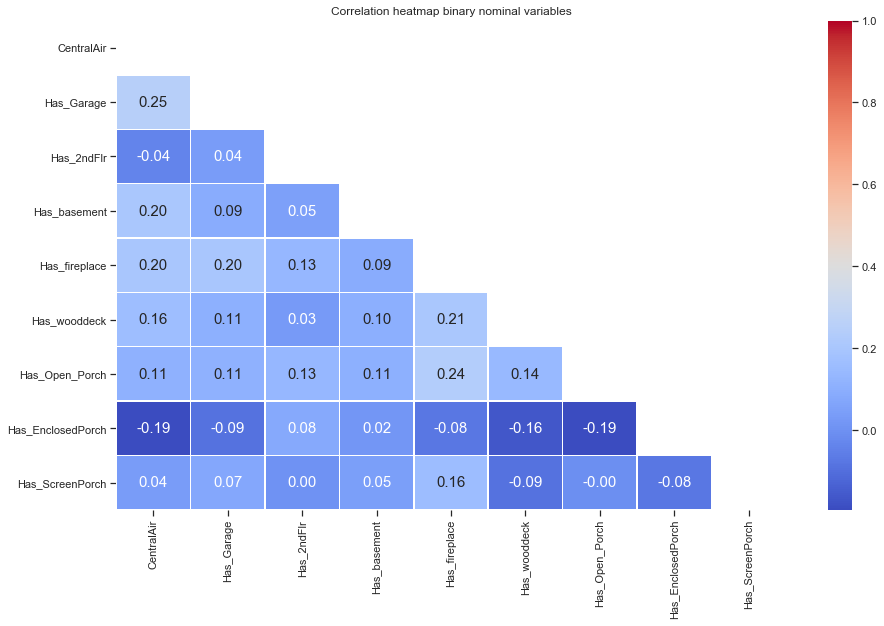

In [51]:
temp = pd.DataFrame(columns=cat_binary_cols, index=cat_binary_cols).fillna(0)
for row in cat_binary_cols:
    a = row
    for col in cat_binary_cols:
        b = col
        temp.loc[a,b] = phi_coefficient(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
          
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(temp, dtype=np.bool))
plt.figure(figsize = (15,9));
# Draw the heatmap with the mask 
sns.heatmap(temp, mask=mask, cmap='coolwarm', fmt = '.2f', linewidths=.5, annot = True);
plt.title("Correlation heatmap binary nominal variables");

There is no association or correlation between the nominal and binary variables.

In [52]:
del(cat_binary_cols)

## EDA - Category and Category analysis

In [53]:
def cramers_v(a,b):
    crosstab = pd.crosstab(a,b)
    chi2 = chi2_contingency(crosstab)[0]  # chi-squared value
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))))

def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return(1)
    else:
        return((s_x - s_xy)/s_x)

In [54]:
category_cols = X_train.select_dtypes(['object', 'category', 'int32']).columns.to_list()
category_cols[:10]

['MSZoning',
 'Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl']

In [55]:
len(category_cols)

28

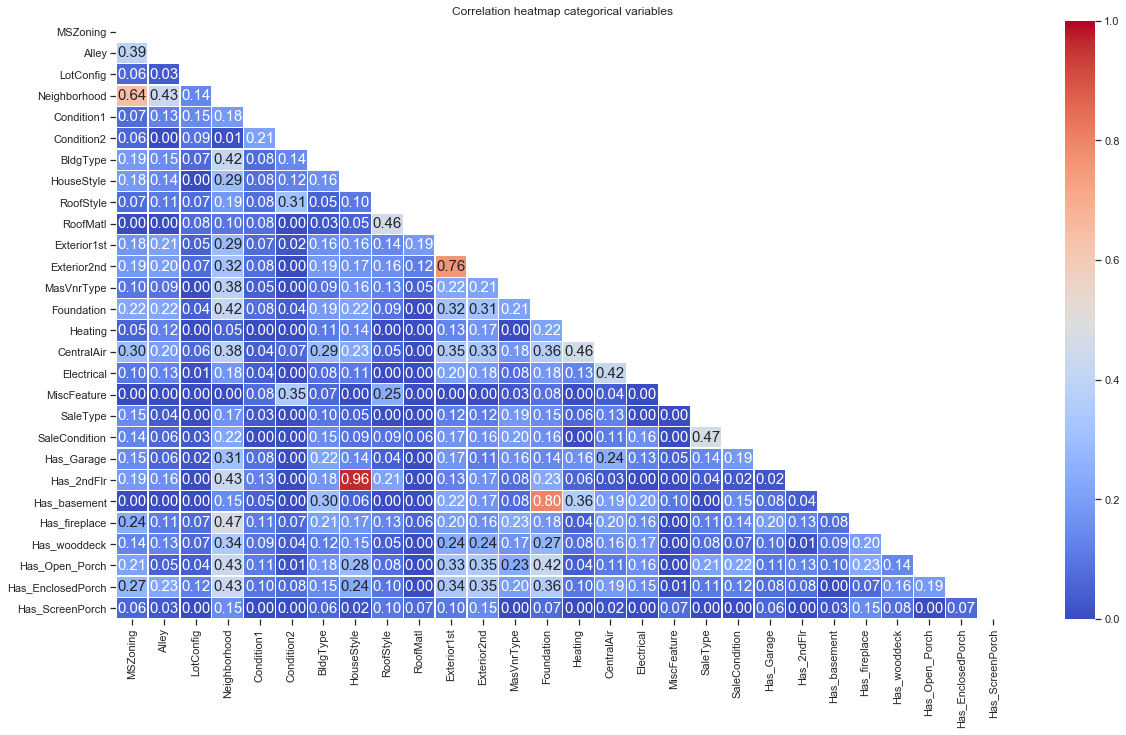

In [56]:
temp = pd.DataFrame(columns=category_cols, index=category_cols).fillna(0)
for row in category_cols:
    a = row
    for col in category_cols:
        b = col
        temp.loc[a,b] = cramers_v(X_train[a],X_train[b])
        temp.loc[b,a] = temp.loc[a,b]
          
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(temp, dtype=np.bool))
plt.figure(figsize = (20,11));
# Draw the heatmap with the mask 
sns.heatmap(temp, cmap='coolwarm', mask = mask,fmt = '.2f', linewidths=.2, annot = True);
plt.title("Correlation heatmap categorical variables");

Deleting columns to remove multicolinearity
- __Neighborhood__ and MSZoning
- __Has_2ndFlr__ and HouseStyle
- Exterior1st and __Exterior2nd__
- Has_basement and __Foundation__


#### Dropping columns

In [57]:
data.drop(columns = ['Neighborhood', 'Has_2ndFlr', 'Exterior2nd', 'Foundation'], inplace = True)
X_train.drop(columns = ['Neighborhood', 'Has_2ndFlr', 'Exterior2nd', 'Foundation'], inplace = True)

In [58]:
del(category_cols, mask, temp)

In [59]:
X_train.shape

(1458, 33)

In [60]:
data.shape

(2917, 32)

In [61]:
X_train.dtypes.value_counts()

object     17
int32       7
int8        3
float64     3
int64       3
dtype: int64

In [62]:
box_cox_cols = X_train.select_dtypes(['float64', 'int8', 'int64']).columns
box_cox_cols

Index(['OverallQual', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'GrLivArea',
       'GarageFinish', 'GarageCars', 'Total_bathrooms', 'SalePrice'],
      dtype='object')

### Applying box-cox transformation

Converting all columns to normal distribution

In [63]:
for col in box_cox_cols[box_cox_cols!='SalePrice']:
    X_train[col] = boxcox1p(X_train[col], boxcox_normmax(X_train[col]+1))
    data[col] = boxcox1p(data[col], boxcox_normmax(data[col]+1))

#### Applying log(1+x) transform on SalePrice

In [64]:
X_train['SalePrice'] = np.log1p(X_train['SalePrice'])

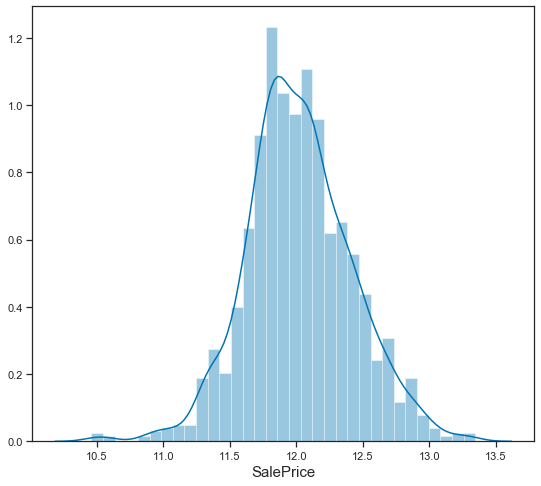

In [65]:
sns.distplot(X_train['SalePrice'], kde = True);

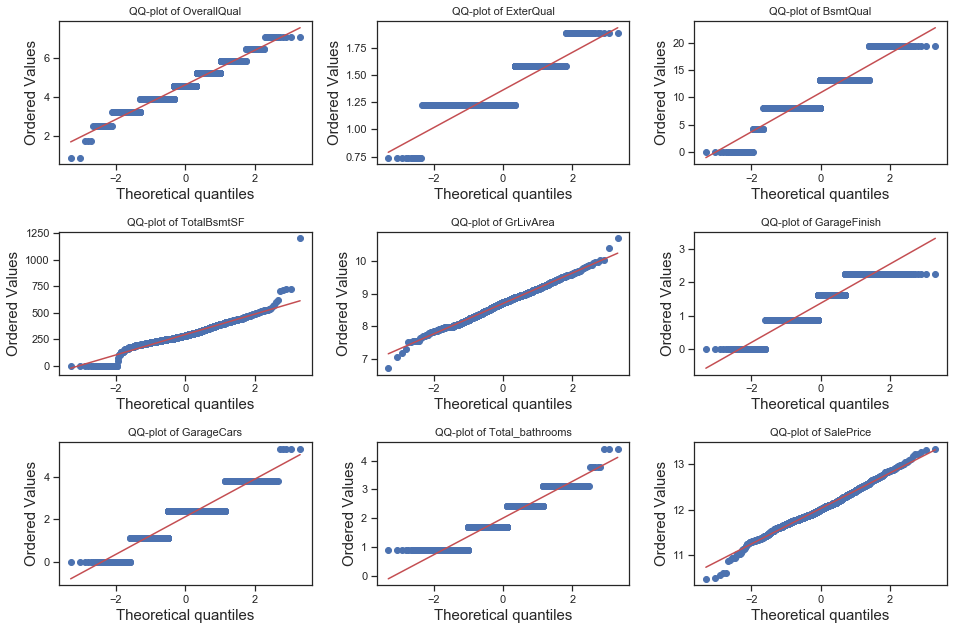

In [66]:
ncols = 3
nrows = math.ceil(len(box_cox_cols)/ncols)
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in box_cox_cols:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    probplot(X_train[col], dist = 'norm', plot = ax)
    str_title = "QQ-plot of {}".format(col)
    ax.set_title(str_title,fontsize=11)

    
plt.tight_layout(); 
plt.show();

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

### Nominal columns

In [ ]:
nominal_cols = X_train.select_dtypes('object').columns.to_list()
nominal_cols

# Modelling

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression

In [68]:
data.shape

(2917, 32)

In [69]:
X_train.shape

(1458, 33)

In [70]:
train = data.iloc[:len(X_train),:].copy()
train['SalePrice'] = X_train['SalePrice'].copy()
test = data.iloc[len(X_train):,:].copy()

In [71]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (1458, 33)
Test shape:  (1459, 32)


In [91]:
X = train.loc[:,train.columns!='SalePrice']
y = train['SalePrice'].copy()
X.shape

(1458, 32)

In [85]:
y.shape

(1458,)

#### one hot encoder

In [72]:
ohe_dict_cols = {}
for col in data.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(data[col].unique()).to_list()
    
# For one-hot encoder
t_k = []
t_v = []
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

In [78]:
num_cols = X_train.select_dtypes('number').columns[~pd.Series(X_train.select_dtypes('number').columns).
                                                   str.contains('^Has')].to_list()

In [87]:
num_cols.remove('SalePrice')

## 1. Linear regression

In [96]:
from time import time
from sklearn.linear_model  import LinearRegression
lin_reg = LinearRegression()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [("colt", colT), ("SKB", skb), ("regl",lin_reg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "regl__fit_intercept":[True,False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))


print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", np.sqrt(-grid.best_score_))

training time: 8.214s
testing time: 0.016s
Best gird parameters :  {'SKB__k': 30, 'regl__fit_intercept': True}
RMSE:  0.4929454335232388


## 2. DecisionTreeRegressor

In [98]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state=0)

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ("dt", dtreg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "dt__splitter": ['best', 'random'],
             "dt__max_depth": [2,3,4,5],
             "dt__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_dt = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE DT: ", np.sqrt(-grid.best_score_))

training time: 70.234s
testing time: 0.018s
Best gird parameters :  {'SKB__k': 20, 'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__splitter': 'best'}
RMSE DT:  0.437022464087678


## 3. Random Forest Regressor

In [99]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ("rf", rfreg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "rf__n_estimators": [10,20,50,100],
             "rf__max_depth": [2,3,4,5],
             "rf__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_rf = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE RF: ", np.sqrt(-grid.best_score_))

training time: 704.18s
testing time: 0.08s
Best gird parameters :  {'SKB__k': 28, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 100}
RMSE RF:  0.3993593185306493


### 4. XGBoost

In [126]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, alpha = 10, n_estimators = 10)

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb), ("xg", xg_reg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31], 
              "xg__learning_rate": [0.1,0.3,0.5,0.7],
             "xg__max_depth": [2,3,4,5],
             "xg__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_XG_1 = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE XG: ", np.sqrt(-grid.best_score_))

training time: 202.084s
testing time: 0.028s
Best gird parameters :  {'SKB__k': 28, 'xg__learning_rate': 0.5, 'xg__max_depth': 5, 'xg__max_features': 'auto'}
RMSE XG:  0.3926012798033706


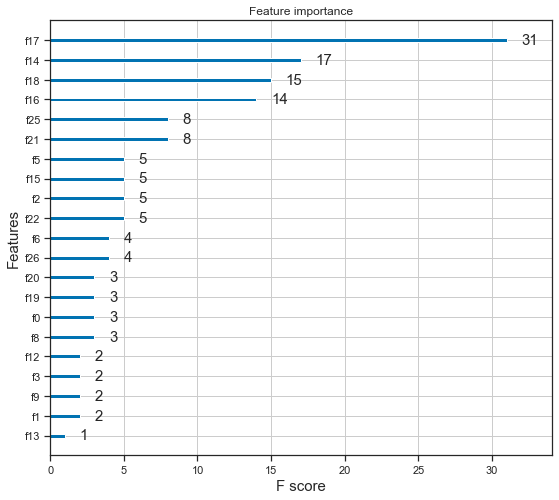

In [102]:
xgb.plot_importance(reg.named_steps['xg'])
plt.rcParams['figure.figsize'] = [9, 10]
plt.show()

## 5.  Ridge regression

In [110]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("ridge", ridge_reg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31], 
              "ridge__alpha": [0.05, 0.07, 0.08, 0.095,1,1.5],
             "ridge__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_ridge = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Ridge: ", np.sqrt(-grid.best_score_))

training time: 40.907s
testing time: 0.015s
Best gird parameters :  {'SKB__k': 31, 'ridge__alpha': 0.05, 'ridge__fit_intercept': True}
RMSE Ridge:  0.4928823192078357


## 6. Lasso Regression

In [112]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("lasso", lasso_reg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "lasso__alpha": [0.05,1,1.5,2],
             "lasso__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", np.sqrt(-grid.best_score_))

training time: 33.957s
testing time: 0.025s
Best gird parameters :  {'SKB__k': 10, 'lasso__alpha': 0.05, 'lasso__fit_intercept': True}
RMSE Lasso:  0.5766534463745029


## 7. Elastic Net regression

In [113]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("elastic", elastic_reg)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "elastic__alpha": [0.05,0.07,1,1.5,2],
             "elastic__fit_intercept": [True, False],
             "elastic__l1_ratio":[.025,0.05, 0.07,0.08, 0.095]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", np.sqrt(-grid.best_score_))

training time: 182.446s
testing time: 0.03s
Best gird parameters :  {'SKB__k': 31, 'elastic__alpha': 0.05, 'elastic__fit_intercept': True, 'elastic__l1_ratio': 0.025}
RMSE Lasso:  0.5057836334875855


## SVR

In [115]:
from sklearn.svm import SVR
svr = SVR()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ("SKB", skb),("svrpara", svr)])
param_grid = {"SKB__k":[10, 15, 20, 22, 25, 28, 30, 31, 32],
              "svrpara__kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
             "svrpara__degree": [2,3,4],
             "svrpara__gamma": ['scale', 'auto'],
             "svrpara__C":[0.5,0.8,1],
             "svrpara__epsilon":[0.08,0.1,0.15,0.2]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_svr = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE SVR: ", np.sqrt(-grid.best_score_))

training time: 6716.832s
testing time: 0.109s
Best gird parameters :  {'SKB__k': 32, 'svrpara__C': 0.8, 'svrpara__degree': 2, 'svrpara__epsilon': 0.15, 'svrpara__gamma': 'scale', 'svrpara__kernel': 'rbf'}
RMSE SVR:  0.4940480981021147


***

# Applying PCA

## 1. Linear Regression

In [118]:
from time import time
from sklearn.linear_model  import LinearRegression
lin_reg = LinearRegression()

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [("colt", colT), ('svd', svd), ("SKB", skb), ("regl",lin_reg)])
param_grid = {'svd__n_components': [5, 10, 15, 18, 20, 22, 25],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "regl__fit_intercept":[True,False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))


print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", np.sqrt(-grid.best_score_))

training time: 49.846s
testing time: 0.047s
Best gird parameters :  {'SKB__k': 25, 'regl__fit_intercept': True, 'svd__n_components': 25}
RMSE:  0.4919679370580567


## 2b DecisionTreeRegressor

In [120]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state=0)

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ('svd', svd), ("SKB", skb), ("dt", dtreg)])
param_grid = {'svd__n_components': [5, 10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "dt__splitter": ['best', 'random'],
             "dt__max_depth": [2,3,4,5],
             "dt__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_dt = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE DT: ", np.sqrt(-grid.best_score_))

training time: 511.433s
testing time: 0.014s
Best gird parameters :  {'SKB__k': 10, 'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__splitter': 'best', 'svd__n_components': 10}
RMSE DT:  0.47318762336535497


## 3b RandomForestRegressor

In [121]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT),('svd', svd), ("SKB", skb), ("rf", rfreg)])
param_grid = {'svd__n_components': [5, 10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "rf__n_estimators": [10,20,50,100],
             "rf__max_depth": [2,3,4,5],
             "rf__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_rf = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE RF: ", np.sqrt(-grid.best_score_))

training time: 2556.22s
testing time: 0.031s
Best gird parameters :  {'SKB__k': 10, 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 100, 'svd__n_components': 20}
RMSE RF:  0.43747770324985996


## 4b. XGBoost

In [122]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, alpha = 10, n_estimators = 10)

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ('svd', svd),("SKB", skb), ("xg", xg_reg)])
param_grid = {'svd__n_components': [5, 10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31], 
              "xg__learning_rate": [0.1,0.3,0.5,0.7],
             "xg__max_depth": [2,3,4,5],
             "xg__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_XG = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE XG: ", np.sqrt(-grid.best_score_))

training time: 2826.055s
testing time: 0.02s
Best gird parameters :  {'SKB__k': 10, 'svd__n_components': 10, 'xg__learning_rate': 0.7, 'xg__max_depth': 3, 'xg__max_features': 'sqrt'}
RMSE XG:  0.4342517509601802


## 5b. Ridge Regression

In [123]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ('svd', svd),("SKB", skb),("ridge", ridge_reg)])
param_grid = {'svd__n_components': [ 10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31], 
              "ridge__alpha": [0.05, 0.07, 0.08, 0.095,1,1.5],
             "ridge__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_ridge = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Ridge: ", np.sqrt(-grid.best_score_))

training time: 293.858s
testing time: 0.025s
Best gird parameters :  {'SKB__k': 30, 'ridge__alpha': 1.5, 'ridge__fit_intercept': True, 'svd__n_components': 30}
RMSE Ridge:  0.4912132695157144


## 6b. Lasso Regression

In [124]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

# Bigger the alpha values the lesser the features that will be selected

pipeline = Pipeline(steps = [('colt', colT), ('svd', svd), ("SKB", skb), ("lasso", lasso_reg)])
param_grid = {'svd__n_components': [10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "lasso__alpha": [0.05,1,1.5,2],
             "lasso__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", np.sqrt(-grid.best_score_))

training time: 197.786s
testing time: 0.025s
Best gird parameters :  {'SKB__k': 10, 'lasso__alpha': 0.05, 'lasso__fit_intercept': True, 'svd__n_components': 15}
RMSE Lasso:  0.542050330241162


## 7b. Elastic net regression

In [125]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet()

colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols)
], remainder = 'passthrough')

skb = SelectKBest(f_regression)

pipeline = Pipeline(steps = [('colt', colT), ('svd', svd), ("SKB", skb),("elastic", elastic_reg)])
param_grid = {'svd__n_components': [10, 15, 20, 25, 30],
              "SKB__k":[10, 15, 20, 22, 25, 28, 30, 31],
              "elastic__alpha": [0.05,0.07,1,1.5,2],
             "elastic__fit_intercept": [True, False],
             "elastic__l1_ratio":[.025,0.05, 0.07,0.08, 0.095]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", np.sqrt(-grid.best_score_))

training time: 1053.391s
testing time: 0.025s
Best gird parameters :  {'SKB__k': 30, 'elastic__alpha': 0.05, 'elastic__fit_intercept': True, 'elastic__l1_ratio': 0.025, 'svd__n_components': 30}
RMSE Lasso:  0.4978507772193024


### Submission

In [130]:
test = pd.read_csv('test.csv')

In [127]:
sub_pred = np.exp(prediction_XG_1)

In [131]:
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = sub_pred
df_output.head()

,Id,SalePrice
0,1461,123940.656250
1,1462,163299.265625
2,1463,166262.343750
3,1464,168316.078125
4,1465,207074.171875


In [132]:
df_output.to_csv('submission_4.csv', index = False)

In [133]:
progress = pd.DataFrame()
progress['date'] = pd.to_datetime(['2020-05-13', '2020-05-25'])
progress['rmse'] = [0.3874, 0.3926]
progress

,date,rmse
0,2020-05-13,0.3874
1,2020-05-25,0.3926


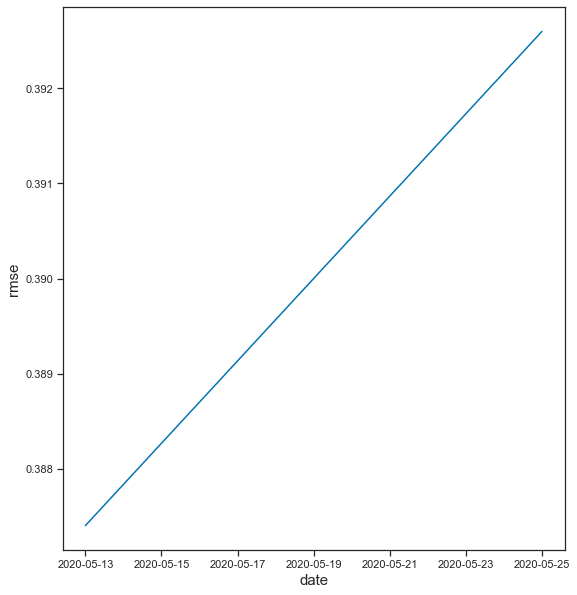

In [134]:
sns.lineplot(data = progress, x = 'date', y = 'rmse');

### Important reference
- [PCA and regression](https://www.kaggle.com/miguelangelnieto/pca-and-regression)
- [Principal Component Regression (PCR)](https://learnche.org/pid/latent-variable-modelling/principal-components-regression)
- [PCA: A Practical Guide to Principal Component Analysis in R & Python](https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/)
- [AV PCA and regression analysis](https://discuss.analyticsvidhya.com/t/pca-in-regression-analysis/13299)
- [Feature selection using KBest](https://www.kaggle.com/jepsds/feature-selection-using-selectkbest)
- [Sklearn SelectKBest Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
- [Feature Selection Methods](https://medium.com/@nmscott14/3-feature-selection-methods-e7ccd6dbf316)